# Enhancing Image Reconstruction with Prediction model using DCGAN

### Experiment 2: Flowers Dataset

This experiment performed on the Flowers Dataset  which has unique images of flowers. 

The 2nd scenario is considered as images of the dataset also have similar patterns, but attributes of images are different like shade and shape of flowers. So, these conditions increase the complexity for training, prediction and inpainting. 

The aim of this experiment is to achieve similar results as Experiment 1 despite of increase in complexity.

In [11]:
# Loading required packages
import os
import cv2
import glob
import torch
import random
import imageio
import torch.nn as nn
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable
import torchvision.datasets as dsets
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import mpmath
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray, expand_dims, log, mean, exp
from image_utils import get_tensor_image, save_tensor_images

In [12]:
# Creating a Cuda Environment 
cudnn.benchmark = True

# Set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  699


# Training DCGAN

In [13]:
# Initializing Hyperparameters for the model.
image_size = 64
nz = 100
nc = 3
D_output_dim = 1
ngf = 128
ndf = 128
ngpu = 1

learning_rate = 0.0002
betas = (0.5, 0.999)
batch_size = 128
num_epochs = 100
def save_checkpoint(state, filename="./data/flowers/checkpoints/flowers_checkpoint.pth.tar"):
    print("=> Saving Checkpoint")
    torch.save(state, filename)

In [14]:
# Performing transformation and loading the dataset.
train_dir = './data/flowers/resized_flowers/train/'
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

flowers_data = dsets.ImageFolder(train_dir, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=flowers_data,
                                          batch_size=batch_size,
                                          shuffle=True)

# Checking the availability of cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, " will be used.\n")

cuda  will be used.



## Generator Network

The Generator network is a neual network that takes a noise vector as an input and generates an image after passing through several hidden layers.

The DCGAN generator has Transpose Convolution layers and includes batch normalization instead of pooling payers.

The output of the network is a Tanh Function providing input to the Discriminator network.

In [15]:
#The Generator Neural Network Model
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
            return output

NetG = Generator(ngpu).to(device)
print(NetG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


## Discriminator Network

The Discriminator network is a neual network that takes real dataset images as an input and it passes through several hidden layers.

The DCGAN generator has Convolution layers and includes batch normalization instead of pooling payers.

It also uses LeakyReLU Activation function and the output of the network is a Sigmoid Function acting as a classifier network.

In [16]:
#The Discriminator Neural Network Model 
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

NetD = Discriminator(ngpu).to(device)
print(NetD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [17]:
# Initializing the Loss function.
criterion = torch.nn.BCELoss()

#Creating Noise input for the Generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Initializing Network Optimizers
G_optimizer = torch.optim.Adam(NetG.parameters(), lr=learning_rate, betas=betas)
D_optimizer = torch.optim.Adam(NetD.parameters(), lr=learning_rate, betas=betas)

G_losses = []
D_losses = []
img_list = []
iters = 0

In [18]:
# Training the DCGAN model

print("Starting Training Loop...")
for epoch in range(num_epochs):
    
    if epoch % 5 == 0:
        checkpoint = {'state_dict1' : NetD.state_dict(), 
                      'optimizer1': D_optimizer.state_dict(),
                     'state_dict2' : NetG.state_dict(), 
                      'optimizer2': G_optimizer.state_dict()}
        save_checkpoint(checkpoint)
    
    for i, (images,targets) in enumerate(data_loader, 0):
        
        # 1st Step: Updating the weights of the neural network of the discriminator

        NetD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real = images.to(device)
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0])*0.9).to(device)
        output = NetD(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1)).to(device)
        fake = NetG(noise)
        target = Variable(torch.zeros(input.size()[0])*0.1).to(device)
        output = NetD(fake.detach())
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        D_optimizer.step()

        # 2nd Step: Updating the weights of the neural network of the generator

        NetG.zero_grad()
        target = Variable(torch.ones(input.size()[0])).to(device)
        output = NetD(fake)
        errG = criterion(output, target)
        errG.backward()
        G_optimizer.step()
        
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, num_epochs, i, len(data_loader), errD.data, errG.data))
        
        # loss values
        D_losses.append(errD.item())
        G_losses.append(errG.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = NetG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./data/flowers/training_results", normalize = True)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./data/flowers/training_results", epoch), normalize = True)

Starting Training Loop...
=> Saving Checkpoint
[0/100][0/62] Loss_D: 1.5303 Loss_G: 10.8858
[0/100][1/62] Loss_D: 2.7087 Loss_G: 9.7927
[0/100][2/62] Loss_D: 1.9109 Loss_G: 11.3522
[0/100][3/62] Loss_D: 1.2141 Loss_G: 10.6575
[0/100][4/62] Loss_D: 1.1843 Loss_G: 15.7955
[0/100][5/62] Loss_D: 0.6116 Loss_G: 11.0824
[0/100][6/62] Loss_D: 2.1442 Loss_G: 18.6902
[0/100][7/62] Loss_D: 0.8065 Loss_G: 18.3486
[0/100][8/62] Loss_D: 0.4448 Loss_G: 13.8141
[0/100][9/62] Loss_D: 0.5577 Loss_G: 13.1347
[0/100][10/62] Loss_D: 0.6498 Loss_G: 17.5843
[0/100][11/62] Loss_D: 0.4513 Loss_G: 16.4690
[0/100][12/62] Loss_D: 0.3716 Loss_G: 9.6882
[0/100][13/62] Loss_D: 2.9237 Loss_G: 21.6007
[0/100][14/62] Loss_D: 1.0483 Loss_G: 21.6708
[0/100][15/62] Loss_D: 0.5142 Loss_G: 20.6321
[0/100][16/62] Loss_D: 0.3810 Loss_G: 19.4765
[0/100][17/62] Loss_D: 0.3733 Loss_G: 18.1038
[0/100][18/62] Loss_D: 0.3854 Loss_G: 16.0554
[0/100][19/62] Loss_D: 0.3785 Loss_G: 12.2612
[0/100][20/62] Loss_D: 0.3983 Loss_G: 9.0270


[2/100][57/62] Loss_D: 0.6814 Loss_G: 2.0860
[2/100][58/62] Loss_D: 0.8555 Loss_G: 3.8924
[2/100][59/62] Loss_D: 0.9318 Loss_G: 1.7867
[2/100][60/62] Loss_D: 0.7175 Loss_G: 2.9628
[2/100][61/62] Loss_D: 0.5612 Loss_G: 2.8074
[3/100][0/62] Loss_D: 0.5957 Loss_G: 3.1324
[3/100][1/62] Loss_D: 0.5117 Loss_G: 3.4402
[3/100][2/62] Loss_D: 0.5778 Loss_G: 2.4404
[3/100][3/62] Loss_D: 0.6934 Loss_G: 3.2283
[3/100][4/62] Loss_D: 0.7380 Loss_G: 2.9092
[3/100][5/62] Loss_D: 0.7134 Loss_G: 3.0066
[3/100][6/62] Loss_D: 0.6270 Loss_G: 4.0150
[3/100][7/62] Loss_D: 0.6586 Loss_G: 1.9583
[3/100][8/62] Loss_D: 0.7733 Loss_G: 4.5797
[3/100][9/62] Loss_D: 0.7128 Loss_G: 2.6027
[3/100][10/62] Loss_D: 0.6553 Loss_G: 4.1556
[3/100][11/62] Loss_D: 0.4552 Loss_G: 3.9058
[3/100][12/62] Loss_D: 0.4493 Loss_G: 3.5726
[3/100][13/62] Loss_D: 0.4321 Loss_G: 3.3242
[3/100][14/62] Loss_D: 0.5029 Loss_G: 4.5167
[3/100][15/62] Loss_D: 0.4412 Loss_G: 4.0258
[3/100][16/62] Loss_D: 0.6335 Loss_G: 4.9478
[3/100][17/62] Loss_

[5/100][54/62] Loss_D: 1.0918 Loss_G: 1.5541
[5/100][55/62] Loss_D: 1.0360 Loss_G: 2.7354
[5/100][56/62] Loss_D: 1.0832 Loss_G: 1.5232
[5/100][57/62] Loss_D: 1.1190 Loss_G: 2.3148
[5/100][58/62] Loss_D: 1.1794 Loss_G: 1.3327
[5/100][59/62] Loss_D: 1.2106 Loss_G: 3.7031
[5/100][60/62] Loss_D: 1.6752 Loss_G: 0.7582
[5/100][61/62] Loss_D: 1.6122 Loss_G: 3.1296
[6/100][0/62] Loss_D: 1.2235 Loss_G: 1.8041
[6/100][1/62] Loss_D: 1.4139 Loss_G: 1.1371
[6/100][2/62] Loss_D: 1.6780 Loss_G: 2.1855
[6/100][3/62] Loss_D: 1.4718 Loss_G: 1.2809
[6/100][4/62] Loss_D: 1.2430 Loss_G: 1.5448
[6/100][5/62] Loss_D: 1.1253 Loss_G: 1.9961
[6/100][6/62] Loss_D: 0.9442 Loss_G: 1.8430
[6/100][7/62] Loss_D: 0.9252 Loss_G: 2.0114
[6/100][8/62] Loss_D: 0.8082 Loss_G: 2.4278
[6/100][9/62] Loss_D: 0.9986 Loss_G: 2.0207
[6/100][10/62] Loss_D: 0.9474 Loss_G: 2.0961
[6/100][11/62] Loss_D: 0.9894 Loss_G: 1.7371
[6/100][12/62] Loss_D: 1.0929 Loss_G: 4.0492
[6/100][13/62] Loss_D: 1.4648 Loss_G: 0.7108
[6/100][14/62] Loss_

[8/100][51/62] Loss_D: 1.1895 Loss_G: 2.0074
[8/100][52/62] Loss_D: 1.0019 Loss_G: 2.3384
[8/100][53/62] Loss_D: 0.8299 Loss_G: 1.8734
[8/100][54/62] Loss_D: 0.8403 Loss_G: 2.1602
[8/100][55/62] Loss_D: 0.9190 Loss_G: 2.9486
[8/100][56/62] Loss_D: 1.0953 Loss_G: 1.2374
[8/100][57/62] Loss_D: 1.1651 Loss_G: 2.9928
[8/100][58/62] Loss_D: 1.4540 Loss_G: 0.9321
[8/100][59/62] Loss_D: 1.4954 Loss_G: 3.4955
[8/100][60/62] Loss_D: 1.5647 Loss_G: 1.2386
[8/100][61/62] Loss_D: 1.1291 Loss_G: 1.8202
[9/100][0/62] Loss_D: 1.0103 Loss_G: 2.7101
[9/100][1/62] Loss_D: 1.1836 Loss_G: 1.3325
[9/100][2/62] Loss_D: 1.0824 Loss_G: 2.1654
[9/100][3/62] Loss_D: 1.0431 Loss_G: 1.7547
[9/100][4/62] Loss_D: 1.1603 Loss_G: 1.5356
[9/100][5/62] Loss_D: 1.2147 Loss_G: 1.6024
[9/100][6/62] Loss_D: 1.1303 Loss_G: 1.6711
[9/100][7/62] Loss_D: 1.1180 Loss_G: 2.2044
[9/100][8/62] Loss_D: 0.9481 Loss_G: 1.2753
[9/100][9/62] Loss_D: 0.9697 Loss_G: 3.1262
[9/100][10/62] Loss_D: 0.9746 Loss_G: 1.3876
[9/100][11/62] Loss_

[11/100][45/62] Loss_D: 1.0857 Loss_G: 1.1747
[11/100][46/62] Loss_D: 0.9205 Loss_G: 5.0281
[11/100][47/62] Loss_D: 0.8444 Loss_G: 1.0336
[11/100][48/62] Loss_D: 1.8365 Loss_G: 8.0170
[11/100][49/62] Loss_D: 3.4973 Loss_G: 2.0259
[11/100][50/62] Loss_D: 0.9320 Loss_G: 0.7248
[11/100][51/62] Loss_D: 1.7032 Loss_G: 2.7439
[11/100][52/62] Loss_D: 1.4332 Loss_G: 1.5961
[11/100][53/62] Loss_D: 1.2453 Loss_G: 1.0832
[11/100][54/62] Loss_D: 1.1087 Loss_G: 1.8973
[11/100][55/62] Loss_D: 1.0557 Loss_G: 1.6129
[11/100][56/62] Loss_D: 0.7492 Loss_G: 2.0607
[11/100][57/62] Loss_D: 0.8443 Loss_G: 1.6011
[11/100][58/62] Loss_D: 0.8957 Loss_G: 2.3545
[11/100][59/62] Loss_D: 0.7623 Loss_G: 2.1477
[11/100][60/62] Loss_D: 0.8093 Loss_G: 1.7303
[11/100][61/62] Loss_D: 0.8208 Loss_G: 2.0720
[12/100][0/62] Loss_D: 0.7942 Loss_G: 1.8721
[12/100][1/62] Loss_D: 0.8375 Loss_G: 2.2807
[12/100][2/62] Loss_D: 0.7457 Loss_G: 1.7582
[12/100][3/62] Loss_D: 0.9249 Loss_G: 3.0002
[12/100][4/62] Loss_D: 0.8726 Loss_G: 

[14/100][38/62] Loss_D: 0.9599 Loss_G: 2.3701
[14/100][39/62] Loss_D: 0.8470 Loss_G: 2.6041
[14/100][40/62] Loss_D: 1.0348 Loss_G: 1.5530
[14/100][41/62] Loss_D: 0.8106 Loss_G: 3.2816
[14/100][42/62] Loss_D: 0.8545 Loss_G: 2.3343
[14/100][43/62] Loss_D: 0.9125 Loss_G: 2.0319
[14/100][44/62] Loss_D: 0.9393 Loss_G: 3.4802
[14/100][45/62] Loss_D: 0.9610 Loss_G: 1.4915
[14/100][46/62] Loss_D: 1.2333 Loss_G: 4.5085
[14/100][47/62] Loss_D: 0.9285 Loss_G: 3.2530
[14/100][48/62] Loss_D: 0.7543 Loss_G: 1.6211
[14/100][49/62] Loss_D: 1.1754 Loss_G: 3.8164
[14/100][50/62] Loss_D: 1.0622 Loss_G: 2.4277
[14/100][51/62] Loss_D: 0.7612 Loss_G: 1.7821
[14/100][52/62] Loss_D: 0.8476 Loss_G: 3.3765
[14/100][53/62] Loss_D: 0.6973 Loss_G: 2.5794
[14/100][54/62] Loss_D: 0.8573 Loss_G: 2.0051
[14/100][55/62] Loss_D: 0.7736 Loss_G: 2.7955
[14/100][56/62] Loss_D: 0.6024 Loss_G: 2.5035
[14/100][57/62] Loss_D: 1.2803 Loss_G: 5.3571
[14/100][58/62] Loss_D: 2.1912 Loss_G: 1.8454
[14/100][59/62] Loss_D: 1.1510 Los

[17/100][31/62] Loss_D: 0.8822 Loss_G: 1.8143
[17/100][32/62] Loss_D: 1.4600 Loss_G: 4.3932
[17/100][33/62] Loss_D: 1.3649 Loss_G: 2.1233
[17/100][34/62] Loss_D: 0.9942 Loss_G: 1.9976
[17/100][35/62] Loss_D: 1.0305 Loss_G: 2.4526
[17/100][36/62] Loss_D: 0.7831 Loss_G: 2.6252
[17/100][37/62] Loss_D: 0.8644 Loss_G: 2.0139
[17/100][38/62] Loss_D: 0.7394 Loss_G: 3.5851
[17/100][39/62] Loss_D: 0.5812 Loss_G: 3.0097
[17/100][40/62] Loss_D: 0.5582 Loss_G: 3.1937
[17/100][41/62] Loss_D: 0.5050 Loss_G: 3.0282
[17/100][42/62] Loss_D: 0.7131 Loss_G: 3.9456
[17/100][43/62] Loss_D: 0.6608 Loss_G: 2.7826
[17/100][44/62] Loss_D: 0.6875 Loss_G: 3.0584
[17/100][45/62] Loss_D: 0.5902 Loss_G: 2.7873
[17/100][46/62] Loss_D: 0.6435 Loss_G: 3.8800
[17/100][47/62] Loss_D: 0.7445 Loss_G: 1.9014
[17/100][48/62] Loss_D: 1.6349 Loss_G: 7.4315
[17/100][49/62] Loss_D: 3.9387 Loss_G: 3.0853
[17/100][50/62] Loss_D: 0.7353 Loss_G: 1.0399
[17/100][51/62] Loss_D: 1.1765 Loss_G: 3.4508
[17/100][52/62] Loss_D: 1.0790 Los

[20/100][24/62] Loss_D: 0.6157 Loss_G: 3.4971
[20/100][25/62] Loss_D: 0.6433 Loss_G: 4.0693
[20/100][26/62] Loss_D: 0.5750 Loss_G: 2.7707
[20/100][27/62] Loss_D: 0.4778 Loss_G: 3.5180
[20/100][28/62] Loss_D: 0.7352 Loss_G: 5.5339
[20/100][29/62] Loss_D: 1.1155 Loss_G: 1.3572
[20/100][30/62] Loss_D: 1.6443 Loss_G: 7.5247
[20/100][31/62] Loss_D: 1.8982 Loss_G: 3.5877
[20/100][32/62] Loss_D: 0.5116 Loss_G: 1.7223
[20/100][33/62] Loss_D: 1.0435 Loss_G: 4.7664
[20/100][34/62] Loss_D: 1.0105 Loss_G: 2.0754
[20/100][35/62] Loss_D: 0.9603 Loss_G: 3.5304
[20/100][36/62] Loss_D: 0.8404 Loss_G: 2.1545
[20/100][37/62] Loss_D: 0.8932 Loss_G: 2.3829
[20/100][38/62] Loss_D: 0.6443 Loss_G: 3.5896
[20/100][39/62] Loss_D: 0.6400 Loss_G: 2.5970
[20/100][40/62] Loss_D: 0.4432 Loss_G: 2.8443
[20/100][41/62] Loss_D: 1.1451 Loss_G: 6.2527
[20/100][42/62] Loss_D: 2.1843 Loss_G: 1.8015
[20/100][43/62] Loss_D: 0.7269 Loss_G: 2.1347
[20/100][44/62] Loss_D: 0.8205 Loss_G: 3.6763
[20/100][45/62] Loss_D: 0.7383 Los

[23/100][17/62] Loss_D: 0.4127 Loss_G: 3.4730
[23/100][18/62] Loss_D: 0.3420 Loss_G: 6.0848
[23/100][19/62] Loss_D: 0.3456 Loss_G: 5.7009
[23/100][20/62] Loss_D: 0.4375 Loss_G: 4.2709
[23/100][21/62] Loss_D: 0.3771 Loss_G: 5.2271
[23/100][22/62] Loss_D: 0.3971 Loss_G: 3.4749
[23/100][23/62] Loss_D: 0.4347 Loss_G: 4.1811
[23/100][24/62] Loss_D: 0.3726 Loss_G: 4.8969
[23/100][25/62] Loss_D: 0.3667 Loss_G: 4.1917
[23/100][26/62] Loss_D: 0.3661 Loss_G: 5.0022
[23/100][27/62] Loss_D: 0.4287 Loss_G: 3.3287
[23/100][28/62] Loss_D: 0.3456 Loss_G: 7.5013
[23/100][29/62] Loss_D: 0.3371 Loss_G: 7.4423
[23/100][30/62] Loss_D: 0.3593 Loss_G: 4.9438
[23/100][31/62] Loss_D: 0.3955 Loss_G: 3.7546
[23/100][32/62] Loss_D: 0.3758 Loss_G: 3.8748
[23/100][33/62] Loss_D: 0.4052 Loss_G: 4.3353
[23/100][34/62] Loss_D: 0.3722 Loss_G: 4.5602
[23/100][35/62] Loss_D: 0.4300 Loss_G: 4.1129
[23/100][36/62] Loss_D: 0.4569 Loss_G: 4.3087
[23/100][37/62] Loss_D: 0.3526 Loss_G: 5.2547
[23/100][38/62] Loss_D: 0.4485 Los

[26/100][10/62] Loss_D: 0.3445 Loss_G: 5.7021
[26/100][11/62] Loss_D: 0.3940 Loss_G: 4.1958
[26/100][12/62] Loss_D: 0.3585 Loss_G: 6.2826
[26/100][13/62] Loss_D: 0.3405 Loss_G: 5.4213
[26/100][14/62] Loss_D: 0.5839 Loss_G: 4.6343
[26/100][15/62] Loss_D: 0.5345 Loss_G: 7.6149
[26/100][16/62] Loss_D: 0.3501 Loss_G: 7.2431
[26/100][17/62] Loss_D: 0.3641 Loss_G: 5.9961
[26/100][18/62] Loss_D: 0.3636 Loss_G: 4.6318
[26/100][19/62] Loss_D: 0.4001 Loss_G: 4.1101
[26/100][20/62] Loss_D: 0.3892 Loss_G: 7.0821
[26/100][21/62] Loss_D: 0.3560 Loss_G: 6.7514
[26/100][22/62] Loss_D: 0.3766 Loss_G: 5.2656
[26/100][23/62] Loss_D: 0.3808 Loss_G: 3.9906
[26/100][24/62] Loss_D: 0.3449 Loss_G: 5.4785
[26/100][25/62] Loss_D: 0.4824 Loss_G: 3.5583
[26/100][26/62] Loss_D: 0.4171 Loss_G: 5.9247
[26/100][27/62] Loss_D: 0.3576 Loss_G: 4.8281
[26/100][28/62] Loss_D: 0.5710 Loss_G: 6.3270
[26/100][29/62] Loss_D: 1.3035 Loss_G: 4.8495
[26/100][30/62] Loss_D: 0.5196 Loss_G: 3.5148
[26/100][31/62] Loss_D: 1.0820 Los

[29/100][3/62] Loss_D: 0.3513 Loss_G: 6.5245
[29/100][4/62] Loss_D: 0.4778 Loss_G: 4.7731
[29/100][5/62] Loss_D: 0.5052 Loss_G: 9.2420
[29/100][6/62] Loss_D: 0.3645 Loss_G: 9.0958
[29/100][7/62] Loss_D: 0.3770 Loss_G: 8.6582
[29/100][8/62] Loss_D: 0.3716 Loss_G: 7.6533
[29/100][9/62] Loss_D: 0.3387 Loss_G: 6.6325
[29/100][10/62] Loss_D: 0.3533 Loss_G: 4.6150
[29/100][11/62] Loss_D: 0.3628 Loss_G: 4.0805
[29/100][12/62] Loss_D: 0.3332 Loss_G: 6.8991
[29/100][13/62] Loss_D: 0.3474 Loss_G: 4.6623
[29/100][14/62] Loss_D: 0.3544 Loss_G: 4.5179
[29/100][15/62] Loss_D: 0.3379 Loss_G: 9.1571
[29/100][16/62] Loss_D: 0.3537 Loss_G: 8.5130
[29/100][17/62] Loss_D: 0.3403 Loss_G: 5.7345
[29/100][18/62] Loss_D: 0.3345 Loss_G: 6.5944
[29/100][19/62] Loss_D: 0.4765 Loss_G: 5.1535
[29/100][20/62] Loss_D: 0.4302 Loss_G: 9.0115
[29/100][21/62] Loss_D: 0.3334 Loss_G: 8.8772
[29/100][22/62] Loss_D: 0.3421 Loss_G: 7.4051
[29/100][23/62] Loss_D: 0.3521 Loss_G: 5.8099
[29/100][24/62] Loss_D: 0.3352 Loss_G: 8.

[31/100][57/62] Loss_D: 0.3481 Loss_G: 4.8411
[31/100][58/62] Loss_D: 0.3597 Loss_G: 7.7872
[31/100][59/62] Loss_D: 0.3390 Loss_G: 5.1357
[31/100][60/62] Loss_D: 0.5128 Loss_G: 7.8181
[31/100][61/62] Loss_D: 0.7893 Loss_G: 10.4364
[32/100][0/62] Loss_D: 0.3798 Loss_G: 7.8678
[32/100][1/62] Loss_D: 0.3447 Loss_G: 5.4273
[32/100][2/62] Loss_D: 0.3398 Loss_G: 10.5736
[32/100][3/62] Loss_D: 0.3483 Loss_G: 9.9381
[32/100][4/62] Loss_D: 0.3347 Loss_G: 7.1214
[32/100][5/62] Loss_D: 0.4018 Loss_G: 4.1216
[32/100][6/62] Loss_D: 0.3542 Loss_G: 5.7426
[32/100][7/62] Loss_D: 0.3924 Loss_G: 5.0055
[32/100][8/62] Loss_D: 0.3440 Loss_G: 10.9152
[32/100][9/62] Loss_D: 0.3322 Loss_G: 10.2852
[32/100][10/62] Loss_D: 0.3384 Loss_G: 5.6158
[32/100][11/62] Loss_D: 0.3368 Loss_G: 7.8698
[32/100][12/62] Loss_D: 0.4579 Loss_G: 7.1773
[32/100][13/62] Loss_D: 0.9006 Loss_G: 7.2959
[32/100][14/62] Loss_D: 0.7028 Loss_G: 2.8402
[32/100][15/62] Loss_D: 0.7632 Loss_G: 5.5924
[32/100][16/62] Loss_D: 0.4459 Loss_G: 6

[34/100][50/62] Loss_D: 0.9820 Loss_G: 7.9196
[34/100][51/62] Loss_D: 2.0055 Loss_G: 6.0826
[34/100][52/62] Loss_D: 0.4533 Loss_G: 2.7158
[34/100][53/62] Loss_D: 0.7543 Loss_G: 5.3450
[34/100][54/62] Loss_D: 0.9445 Loss_G: 1.6729
[34/100][55/62] Loss_D: 1.2164 Loss_G: 5.8527
[34/100][56/62] Loss_D: 1.2796 Loss_G: 4.5026
[34/100][57/62] Loss_D: 0.3918 Loss_G: 2.6184
[34/100][58/62] Loss_D: 0.4347 Loss_G: 3.6910
[34/100][59/62] Loss_D: 0.7714 Loss_G: 5.5766
[34/100][60/62] Loss_D: 1.0469 Loss_G: 4.3701
[34/100][61/62] Loss_D: 1.3170 Loss_G: 4.7621
=> Saving Checkpoint
[35/100][0/62] Loss_D: 1.0005 Loss_G: 6.7597
[35/100][1/62] Loss_D: 0.4024 Loss_G: 2.8401
[35/100][2/62] Loss_D: 0.3413 Loss_G: 5.9910
[35/100][3/62] Loss_D: 0.3679 Loss_G: 4.9367
[35/100][4/62] Loss_D: 0.9538 Loss_G: 5.1009
[35/100][5/62] Loss_D: 1.0108 Loss_G: 7.1974
[35/100][6/62] Loss_D: 0.3821 Loss_G: 4.0346
[35/100][7/62] Loss_D: 0.3990 Loss_G: 3.5456
[35/100][8/62] Loss_D: 0.4703 Loss_G: 3.9887
[35/100][9/62] Loss_D:

[37/100][43/62] Loss_D: 0.3354 Loss_G: 5.3875
[37/100][44/62] Loss_D: 0.3307 Loss_G: 7.4252
[37/100][45/62] Loss_D: 0.3400 Loss_G: 5.0461
[37/100][46/62] Loss_D: 0.3306 Loss_G: 7.1919
[37/100][47/62] Loss_D: 0.3369 Loss_G: 6.2442
[37/100][48/62] Loss_D: 0.3494 Loss_G: 5.1708
[37/100][49/62] Loss_D: 0.3421 Loss_G: 5.3240
[37/100][50/62] Loss_D: 0.3353 Loss_G: 8.1156
[37/100][51/62] Loss_D: 0.3324 Loss_G: 6.5018
[37/100][52/62] Loss_D: 0.3439 Loss_G: 5.3242
[37/100][53/62] Loss_D: 0.3340 Loss_G: 5.7215
[37/100][54/62] Loss_D: 0.3316 Loss_G: 8.9434
[37/100][55/62] Loss_D: 0.3345 Loss_G: 7.8028
[37/100][56/62] Loss_D: 0.3362 Loss_G: 6.1198
[37/100][57/62] Loss_D: 0.3440 Loss_G: 5.5828
[37/100][58/62] Loss_D: 0.3394 Loss_G: 5.7125
[37/100][59/62] Loss_D: 0.3299 Loss_G: 7.7340
[37/100][60/62] Loss_D: 0.3831 Loss_G: 5.5225
[37/100][61/62] Loss_D: 0.3352 Loss_G: 5.2606
[38/100][0/62] Loss_D: 0.3487 Loss_G: 5.0482
[38/100][1/62] Loss_D: 0.3349 Loss_G: 6.9226
[38/100][2/62] Loss_D: 0.3444 Loss_G

[40/100][35/62] Loss_D: 0.3487 Loss_G: 9.4830
[40/100][36/62] Loss_D: 0.3403 Loss_G: 6.3640
[40/100][37/62] Loss_D: 0.3288 Loss_G: 9.6251
[40/100][38/62] Loss_D: 0.3505 Loss_G: 4.9081
[40/100][39/62] Loss_D: 0.3295 Loss_G: 8.8784
[40/100][40/62] Loss_D: 0.3398 Loss_G: 6.1908
[40/100][41/62] Loss_D: 0.3290 Loss_G: 12.4849
[40/100][42/62] Loss_D: 0.3335 Loss_G: 11.5930
[40/100][43/62] Loss_D: 0.3295 Loss_G: 7.4427
[40/100][44/62] Loss_D: 0.3291 Loss_G: 7.6099
[40/100][45/62] Loss_D: 0.3275 Loss_G: 8.8132
[40/100][46/62] Loss_D: 0.3376 Loss_G: 5.2815
[40/100][47/62] Loss_D: 0.3382 Loss_G: 10.3632
[40/100][48/62] Loss_D: 0.3299 Loss_G: 8.8698
[40/100][49/62] Loss_D: 0.3433 Loss_G: 5.5174
[40/100][50/62] Loss_D: 0.3310 Loss_G: 11.7725
[40/100][51/62] Loss_D: 0.3287 Loss_G: 11.5544
[40/100][52/62] Loss_D: 0.3560 Loss_G: 8.7742
[40/100][53/62] Loss_D: 0.3395 Loss_G: 6.1591
[40/100][54/62] Loss_D: 0.3298 Loss_G: 8.6417
[40/100][55/62] Loss_D: 0.3303 Loss_G: 6.3664
[40/100][56/62] Loss_D: 0.334

[43/100][27/62] Loss_D: 0.3688 Loss_G: 7.0611
[43/100][28/62] Loss_D: 0.7534 Loss_G: 10.4299
[43/100][29/62] Loss_D: 1.6238 Loss_G: 5.8053
[43/100][30/62] Loss_D: 0.6629 Loss_G: 5.5968
[43/100][31/62] Loss_D: 0.3986 Loss_G: 8.0375
[43/100][32/62] Loss_D: 0.3753 Loss_G: 4.7351
[43/100][33/62] Loss_D: 0.4414 Loss_G: 3.7832
[43/100][34/62] Loss_D: 0.3790 Loss_G: 4.7828
[43/100][35/62] Loss_D: 1.8835 Loss_G: 10.3118
[43/100][36/62] Loss_D: 4.1556 Loss_G: 6.6346
[43/100][37/62] Loss_D: 0.5866 Loss_G: 1.9700
[43/100][38/62] Loss_D: 0.8795 Loss_G: 4.1451
[43/100][39/62] Loss_D: 0.6104 Loss_G: 4.2325
[43/100][40/62] Loss_D: 0.5724 Loss_G: 3.5614
[43/100][41/62] Loss_D: 0.4542 Loss_G: 3.2289
[43/100][42/62] Loss_D: 0.4610 Loss_G: 3.6882
[43/100][43/62] Loss_D: 0.4887 Loss_G: 3.9780
[43/100][44/62] Loss_D: 0.4849 Loss_G: 3.3758
[43/100][45/62] Loss_D: 0.5153 Loss_G: 3.4244
[43/100][46/62] Loss_D: 0.4087 Loss_G: 3.9468
[43/100][47/62] Loss_D: 0.9140 Loss_G: 6.7954
[43/100][48/62] Loss_D: 1.5505 L

[46/100][20/62] Loss_D: 0.3470 Loss_G: 5.4119
[46/100][21/62] Loss_D: 0.3569 Loss_G: 4.5633
[46/100][22/62] Loss_D: 0.4194 Loss_G: 4.0566
[46/100][23/62] Loss_D: 1.1033 Loss_G: 7.6426
[46/100][24/62] Loss_D: 2.9687 Loss_G: 5.9823
[46/100][25/62] Loss_D: 0.5353 Loss_G: 2.8145
[46/100][26/62] Loss_D: 0.3696 Loss_G: 3.8559
[46/100][27/62] Loss_D: 0.4970 Loss_G: 3.4299
[46/100][28/62] Loss_D: 0.5015 Loss_G: 3.8591
[46/100][29/62] Loss_D: 0.4799 Loss_G: 3.5564
[46/100][30/62] Loss_D: 0.3643 Loss_G: 4.3279
[46/100][31/62] Loss_D: 1.1195 Loss_G: 6.0143
[46/100][32/62] Loss_D: 1.3012 Loss_G: 4.3113
[46/100][33/62] Loss_D: 0.5185 Loss_G: 2.4974
[46/100][34/62] Loss_D: 0.5578 Loss_G: 3.9005
[46/100][35/62] Loss_D: 0.5700 Loss_G: 2.8444
[46/100][36/62] Loss_D: 0.4239 Loss_G: 3.3712
[46/100][37/62] Loss_D: 0.7474 Loss_G: 5.2333
[46/100][38/62] Loss_D: 0.5747 Loss_G: 6.5733
[46/100][39/62] Loss_D: 0.4232 Loss_G: 2.9214
[46/100][40/62] Loss_D: 0.3589 Loss_G: 7.2936
[46/100][41/62] Loss_D: 0.3500 Los

[49/100][13/62] Loss_D: 0.3596 Loss_G: 5.6499
[49/100][14/62] Loss_D: 0.3847 Loss_G: 3.8907
[49/100][15/62] Loss_D: 0.3705 Loss_G: 4.2216
[49/100][16/62] Loss_D: 0.3442 Loss_G: 5.7820
[49/100][17/62] Loss_D: 0.6260 Loss_G: 6.1525
[49/100][18/62] Loss_D: 0.6928 Loss_G: 9.4747
[49/100][19/62] Loss_D: 0.3387 Loss_G: 9.4790
[49/100][20/62] Loss_D: 0.3592 Loss_G: 8.9333
[49/100][21/62] Loss_D: 0.3781 Loss_G: 8.3181
[49/100][22/62] Loss_D: 0.3443 Loss_G: 7.8984
[49/100][23/62] Loss_D: 0.3573 Loss_G: 6.5989
[49/100][24/62] Loss_D: 0.3443 Loss_G: 5.1035
[49/100][25/62] Loss_D: 0.4121 Loss_G: 3.8358
[49/100][26/62] Loss_D: 0.3428 Loss_G: 6.0879
[49/100][27/62] Loss_D: 0.3825 Loss_G: 3.8437
[49/100][28/62] Loss_D: 0.3387 Loss_G: 6.7671
[49/100][29/62] Loss_D: 0.3422 Loss_G: 7.1024
[49/100][30/62] Loss_D: 0.3356 Loss_G: 6.3595
[49/100][31/62] Loss_D: 0.3611 Loss_G: 4.1433
[49/100][32/62] Loss_D: 0.4723 Loss_G: 4.2300
[49/100][33/62] Loss_D: 0.3988 Loss_G: 6.6118
[49/100][34/62] Loss_D: 0.3387 Los

[52/100][6/62] Loss_D: 0.3880 Loss_G: 5.4098
[52/100][7/62] Loss_D: 0.4038 Loss_G: 3.7551
[52/100][8/62] Loss_D: 0.3661 Loss_G: 4.9540
[52/100][9/62] Loss_D: 0.4110 Loss_G: 4.0784
[52/100][10/62] Loss_D: 0.3843 Loss_G: 5.2297
[52/100][11/62] Loss_D: 0.3587 Loss_G: 4.0219
[52/100][12/62] Loss_D: 0.6151 Loss_G: 4.2376
[52/100][13/62] Loss_D: 0.4357 Loss_G: 6.8611
[52/100][14/62] Loss_D: 0.3773 Loss_G: 5.1427
[52/100][15/62] Loss_D: 0.3592 Loss_G: 3.8240
[52/100][16/62] Loss_D: 0.3642 Loss_G: 5.3096
[52/100][17/62] Loss_D: 0.5032 Loss_G: 4.3292
[52/100][18/62] Loss_D: 0.4089 Loss_G: 8.6685
[52/100][19/62] Loss_D: 0.3503 Loss_G: 8.1851
[52/100][20/62] Loss_D: 0.3363 Loss_G: 6.8751
[52/100][21/62] Loss_D: 0.3542 Loss_G: 4.6170
[52/100][22/62] Loss_D: 0.3746 Loss_G: 4.3742
[52/100][23/62] Loss_D: 0.3398 Loss_G: 6.9177
[52/100][24/62] Loss_D: 0.3446 Loss_G: 4.8586
[52/100][25/62] Loss_D: 0.3421 Loss_G: 6.9008
[52/100][26/62] Loss_D: 0.3369 Loss_G: 6.9360
[52/100][27/62] Loss_D: 0.3413 Loss_G:

[54/100][61/62] Loss_D: 0.3309 Loss_G: 7.7787
=> Saving Checkpoint
[55/100][0/62] Loss_D: 0.3336 Loss_G: 6.0729
[55/100][1/62] Loss_D: 0.3328 Loss_G: 5.6574
[55/100][2/62] Loss_D: 0.3521 Loss_G: 9.3301
[55/100][3/62] Loss_D: 0.3286 Loss_G: 9.5515
[55/100][4/62] Loss_D: 0.3307 Loss_G: 8.7468
[55/100][5/62] Loss_D: 0.3317 Loss_G: 7.0348
[55/100][6/62] Loss_D: 0.3433 Loss_G: 5.0998
[55/100][7/62] Loss_D: 0.3275 Loss_G: 9.2923
[55/100][8/62] Loss_D: 0.3310 Loss_G: 7.4708
[55/100][9/62] Loss_D: 0.3468 Loss_G: 7.9908
[55/100][10/62] Loss_D: 0.3350 Loss_G: 4.9024
[55/100][11/62] Loss_D: 0.3532 Loss_G: 8.2051
[55/100][12/62] Loss_D: 0.3377 Loss_G: 6.8152
[55/100][13/62] Loss_D: 0.3582 Loss_G: 4.5937
[55/100][14/62] Loss_D: 0.3310 Loss_G: 8.4202
[55/100][15/62] Loss_D: 0.3334 Loss_G: 5.5187
[55/100][16/62] Loss_D: 0.3471 Loss_G: 5.6623
[55/100][17/62] Loss_D: 0.3298 Loss_G: 6.3150
[55/100][18/62] Loss_D: 0.4093 Loss_G: 5.0645
[55/100][19/62] Loss_D: 0.3420 Loss_G: 10.3637
[55/100][20/62] Loss_D

[57/100][54/62] Loss_D: 0.3549 Loss_G: 6.2099
[57/100][55/62] Loss_D: 0.4476 Loss_G: 4.2029
[57/100][56/62] Loss_D: 0.3544 Loss_G: 7.2107
[57/100][57/62] Loss_D: 0.5057 Loss_G: 4.3555
[57/100][58/62] Loss_D: 0.5216 Loss_G: 6.8342
[57/100][59/62] Loss_D: 0.3593 Loss_G: 5.3432
[57/100][60/62] Loss_D: 0.8335 Loss_G: 7.7870
[57/100][61/62] Loss_D: 1.1058 Loss_G: 8.7093
[58/100][0/62] Loss_D: 0.3871 Loss_G: 6.9039
[58/100][1/62] Loss_D: 0.4194 Loss_G: 4.0017
[58/100][2/62] Loss_D: 0.9336 Loss_G: 6.4394
[58/100][3/62] Loss_D: 1.6131 Loss_G: 1.9571
[58/100][4/62] Loss_D: 1.4270 Loss_G: 7.5142
[58/100][5/62] Loss_D: 1.4687 Loss_G: 2.4512
[58/100][6/62] Loss_D: 0.4381 Loss_G: 2.8883
[58/100][7/62] Loss_D: 0.7920 Loss_G: 5.5549
[58/100][8/62] Loss_D: 0.4510 Loss_G: 6.4468
[58/100][9/62] Loss_D: 0.4872 Loss_G: 2.9462
[58/100][10/62] Loss_D: 0.4003 Loss_G: 4.3964
[58/100][11/62] Loss_D: 0.3768 Loss_G: 4.7800
[58/100][12/62] Loss_D: 0.9123 Loss_G: 6.2439
[58/100][13/62] Loss_D: 1.8454 Loss_G: 4.917

[60/100][47/62] Loss_D: 1.5361 Loss_G: 3.9836
[60/100][48/62] Loss_D: 0.7959 Loss_G: 6.0913
[60/100][49/62] Loss_D: 0.6458 Loss_G: 5.2148
[60/100][50/62] Loss_D: 0.8503 Loss_G: 2.6721
[60/100][51/62] Loss_D: 0.7353 Loss_G: 3.6091
[60/100][52/62] Loss_D: 0.5872 Loss_G: 3.9446
[60/100][53/62] Loss_D: 0.4116 Loss_G: 5.3880
[60/100][54/62] Loss_D: 0.3870 Loss_G: 4.6484
[60/100][55/62] Loss_D: 0.5774 Loss_G: 3.7536
[60/100][56/62] Loss_D: 0.4077 Loss_G: 4.6076
[60/100][57/62] Loss_D: 0.5644 Loss_G: 3.3123
[60/100][58/62] Loss_D: 0.5236 Loss_G: 3.7547
[60/100][59/62] Loss_D: 0.6947 Loss_G: 4.7433
[60/100][60/62] Loss_D: 0.4905 Loss_G: 4.8803
[60/100][61/62] Loss_D: 0.3847 Loss_G: 4.3858
[61/100][0/62] Loss_D: 0.3715 Loss_G: 4.5125
[61/100][1/62] Loss_D: 0.7703 Loss_G: 6.0383
[61/100][2/62] Loss_D: 0.9136 Loss_G: 5.3002
[61/100][3/62] Loss_D: 0.4800 Loss_G: 3.6962
[61/100][4/62] Loss_D: 0.3425 Loss_G: 6.3003
[61/100][5/62] Loss_D: 0.3673 Loss_G: 4.2928
[61/100][6/62] Loss_D: 0.3546 Loss_G: 5.

[63/100][40/62] Loss_D: 0.3379 Loss_G: 8.6560
[63/100][41/62] Loss_D: 0.3386 Loss_G: 7.2749
[63/100][42/62] Loss_D: 0.4068 Loss_G: 4.3028
[63/100][43/62] Loss_D: 0.3413 Loss_G: 7.2571
[63/100][44/62] Loss_D: 0.3485 Loss_G: 4.6436
[63/100][45/62] Loss_D: 0.3318 Loss_G: 8.3409
[63/100][46/62] Loss_D: 0.3327 Loss_G: 6.8090
[63/100][47/62] Loss_D: 0.3712 Loss_G: 3.8015
[63/100][48/62] Loss_D: 0.3458 Loss_G: 7.2628
[63/100][49/62] Loss_D: 0.3798 Loss_G: 5.0301
[63/100][50/62] Loss_D: 0.3318 Loss_G: 8.4593
[63/100][51/62] Loss_D: 0.3521 Loss_G: 6.5801
[63/100][52/62] Loss_D: 0.3318 Loss_G: 7.7242
[63/100][53/62] Loss_D: 0.3470 Loss_G: 4.5975
[63/100][54/62] Loss_D: 0.3323 Loss_G: 8.9105
[63/100][55/62] Loss_D: 0.3327 Loss_G: 8.5861
[63/100][56/62] Loss_D: 0.3327 Loss_G: 6.8116
[63/100][57/62] Loss_D: 0.3537 Loss_G: 4.8127
[63/100][58/62] Loss_D: 0.3898 Loss_G: 6.4522
[63/100][59/62] Loss_D: 0.4966 Loss_G: 5.4171
[63/100][60/62] Loss_D: 0.3808 Loss_G: 8.0639
[63/100][61/62] Loss_D: 0.3465 Los

[66/100][33/62] Loss_D: 0.7733 Loss_G: 6.8956
[66/100][34/62] Loss_D: 1.0596 Loss_G: 2.5499
[66/100][35/62] Loss_D: 0.4147 Loss_G: 4.8402
[66/100][36/62] Loss_D: 0.4950 Loss_G: 4.3423
[66/100][37/62] Loss_D: 0.3950 Loss_G: 4.6395
[66/100][38/62] Loss_D: 0.4971 Loss_G: 4.2015
[66/100][39/62] Loss_D: 0.3987 Loss_G: 7.4293
[66/100][40/62] Loss_D: 0.3424 Loss_G: 6.5081
[66/100][41/62] Loss_D: 0.4214 Loss_G: 4.3972
[66/100][42/62] Loss_D: 0.3555 Loss_G: 5.5155
[66/100][43/62] Loss_D: 0.3812 Loss_G: 4.3571
[66/100][44/62] Loss_D: 0.4803 Loss_G: 4.3579
[66/100][45/62] Loss_D: 0.3993 Loss_G: 5.9229
[66/100][46/62] Loss_D: 0.3520 Loss_G: 4.8722
[66/100][47/62] Loss_D: 0.5518 Loss_G: 5.6477
[66/100][48/62] Loss_D: 0.6469 Loss_G: 5.1822
[66/100][49/62] Loss_D: 0.5586 Loss_G: 3.8322
[66/100][50/62] Loss_D: 0.3699 Loss_G: 7.7608
[66/100][51/62] Loss_D: 0.3517 Loss_G: 6.6281
[66/100][52/62] Loss_D: 0.3831 Loss_G: 3.8736
[66/100][53/62] Loss_D: 0.3756 Loss_G: 5.2405
[66/100][54/62] Loss_D: 0.5468 Los

[69/100][26/62] Loss_D: 0.3914 Loss_G: 6.7824
[69/100][27/62] Loss_D: 0.4167 Loss_G: 3.2874
[69/100][28/62] Loss_D: 0.6562 Loss_G: 8.1915
[69/100][29/62] Loss_D: 0.5901 Loss_G: 8.8810
[69/100][30/62] Loss_D: 0.3381 Loss_G: 5.4860
[69/100][31/62] Loss_D: 0.3397 Loss_G: 5.3490
[69/100][32/62] Loss_D: 0.3593 Loss_G: 5.3841
[69/100][33/62] Loss_D: 0.4489 Loss_G: 4.8053
[69/100][34/62] Loss_D: 0.3914 Loss_G: 7.6409
[69/100][35/62] Loss_D: 0.4147 Loss_G: 4.8779
[69/100][36/62] Loss_D: 0.3460 Loss_G: 6.9835
[69/100][37/62] Loss_D: 0.3616 Loss_G: 4.8053
[69/100][38/62] Loss_D: 0.4215 Loss_G: 8.6349
[69/100][39/62] Loss_D: 0.4418 Loss_G: 7.8318
[69/100][40/62] Loss_D: 0.4698 Loss_G: 5.0698
[69/100][41/62] Loss_D: 0.4060 Loss_G: 6.2713
[69/100][42/62] Loss_D: 0.5788 Loss_G: 7.9333
[69/100][43/62] Loss_D: 0.4781 Loss_G: 5.4751
[69/100][44/62] Loss_D: 1.1987 Loss_G: 11.6347
[69/100][45/62] Loss_D: 4.6798 Loss_G: 7.2075
[69/100][46/62] Loss_D: 0.3879 Loss_G: 3.5943
[69/100][47/62] Loss_D: 0.7589 Lo

[72/100][19/62] Loss_D: 0.3417 Loss_G: 8.3751
[72/100][20/62] Loss_D: 0.3394 Loss_G: 8.4927
[72/100][21/62] Loss_D: 0.3497 Loss_G: 6.4105
[72/100][22/62] Loss_D: 0.4323 Loss_G: 4.2415
[72/100][23/62] Loss_D: 0.4283 Loss_G: 4.4782
[72/100][24/62] Loss_D: 0.3917 Loss_G: 4.8852
[72/100][25/62] Loss_D: 0.3863 Loss_G: 5.2208
[72/100][26/62] Loss_D: 0.3515 Loss_G: 7.2161
[72/100][27/62] Loss_D: 0.3380 Loss_G: 5.6624
[72/100][28/62] Loss_D: 0.3437 Loss_G: 7.2609
[72/100][29/62] Loss_D: 0.3373 Loss_G: 6.0541
[72/100][30/62] Loss_D: 0.3832 Loss_G: 4.3093
[72/100][31/62] Loss_D: 0.3628 Loss_G: 5.7349
[72/100][32/62] Loss_D: 0.3837 Loss_G: 3.6484
[72/100][33/62] Loss_D: 0.3379 Loss_G: 6.2656
[72/100][34/62] Loss_D: 0.3507 Loss_G: 4.7041
[72/100][35/62] Loss_D: 0.3807 Loss_G: 4.4432
[72/100][36/62] Loss_D: 0.5076 Loss_G: 5.2488
[72/100][37/62] Loss_D: 0.3656 Loss_G: 5.9314
[72/100][38/62] Loss_D: 0.3581 Loss_G: 7.6342
[72/100][39/62] Loss_D: 0.3535 Loss_G: 7.3932
[72/100][40/62] Loss_D: 0.3915 Los

[75/100][12/62] Loss_D: 0.5527 Loss_G: 5.6377
[75/100][13/62] Loss_D: 0.4394 Loss_G: 7.8629
[75/100][14/62] Loss_D: 0.3437 Loss_G: 7.1230
[75/100][15/62] Loss_D: 0.4579 Loss_G: 5.1329
[75/100][16/62] Loss_D: 0.3642 Loss_G: 8.9230
[75/100][17/62] Loss_D: 0.3444 Loss_G: 9.1251
[75/100][18/62] Loss_D: 0.3641 Loss_G: 8.2980
[75/100][19/62] Loss_D: 0.3462 Loss_G: 5.7108
[75/100][20/62] Loss_D: 0.3521 Loss_G: 4.7059
[75/100][21/62] Loss_D: 0.3367 Loss_G: 6.1739
[75/100][22/62] Loss_D: 0.4043 Loss_G: 4.9104
[75/100][23/62] Loss_D: 0.3992 Loss_G: 4.6681
[75/100][24/62] Loss_D: 0.4147 Loss_G: 5.1558
[75/100][25/62] Loss_D: 0.3453 Loss_G: 7.3733
[75/100][26/62] Loss_D: 0.3878 Loss_G: 5.2268
[75/100][27/62] Loss_D: 0.3732 Loss_G: 4.9171
[75/100][28/62] Loss_D: 0.3870 Loss_G: 4.8168
[75/100][29/62] Loss_D: 0.3617 Loss_G: 7.3408
[75/100][30/62] Loss_D: 0.3358 Loss_G: 6.1988
[75/100][31/62] Loss_D: 0.4529 Loss_G: 5.0522
[75/100][32/62] Loss_D: 0.3574 Loss_G: 8.0930
[75/100][33/62] Loss_D: 0.3321 Los

[78/100][5/62] Loss_D: 0.3373 Loss_G: 8.7749
[78/100][6/62] Loss_D: 0.3468 Loss_G: 8.2494
[78/100][7/62] Loss_D: 0.3470 Loss_G: 6.4422
[78/100][8/62] Loss_D: 0.3449 Loss_G: 4.5896
[78/100][9/62] Loss_D: 0.3465 Loss_G: 5.3760
[78/100][10/62] Loss_D: 0.3338 Loss_G: 7.0121
[78/100][11/62] Loss_D: 0.3721 Loss_G: 4.9023
[78/100][12/62] Loss_D: 0.3724 Loss_G: 4.6970
[78/100][13/62] Loss_D: 0.4743 Loss_G: 6.3686
[78/100][14/62] Loss_D: 0.6975 Loss_G: 6.4484
[78/100][15/62] Loss_D: 0.4054 Loss_G: 5.2404
[78/100][16/62] Loss_D: 1.2319 Loss_G: 11.8372
[78/100][17/62] Loss_D: 4.0595 Loss_G: 6.0972
[78/100][18/62] Loss_D: 0.4955 Loss_G: 3.6706
[78/100][19/62] Loss_D: 0.8683 Loss_G: 5.6642
[78/100][20/62] Loss_D: 0.3794 Loss_G: 6.5204
[78/100][21/62] Loss_D: 1.0137 Loss_G: 2.5148
[78/100][22/62] Loss_D: 0.6674 Loss_G: 4.3362
[78/100][23/62] Loss_D: 0.6047 Loss_G: 5.5268
[78/100][24/62] Loss_D: 0.4222 Loss_G: 6.0996
[78/100][25/62] Loss_D: 0.3560 Loss_G: 5.9239
[78/100][26/62] Loss_D: 0.4071 Loss_G:

[80/100][60/62] Loss_D: 0.3498 Loss_G: 4.7102
[80/100][61/62] Loss_D: 0.3334 Loss_G: 9.0859
[81/100][0/62] Loss_D: 0.3306 Loss_G: 9.7122
[81/100][1/62] Loss_D: 0.3422 Loss_G: 8.8625
[81/100][2/62] Loss_D: 0.3312 Loss_G: 6.4249
[81/100][3/62] Loss_D: 0.3548 Loss_G: 5.0189
[81/100][4/62] Loss_D: 0.3317 Loss_G: 6.7493
[81/100][5/62] Loss_D: 0.3336 Loss_G: 6.4002
[81/100][6/62] Loss_D: 0.4095 Loss_G: 4.9337
[81/100][7/62] Loss_D: 0.3549 Loss_G: 6.1346
[81/100][8/62] Loss_D: 0.4051 Loss_G: 4.7939
[81/100][9/62] Loss_D: 0.3538 Loss_G: 5.1877
[81/100][10/62] Loss_D: 0.3383 Loss_G: 6.5497
[81/100][11/62] Loss_D: 0.4098 Loss_G: 3.1736
[81/100][12/62] Loss_D: 0.3450 Loss_G: 8.3402
[81/100][13/62] Loss_D: 0.3452 Loss_G: 9.1085
[81/100][14/62] Loss_D: 0.3302 Loss_G: 7.5754
[81/100][15/62] Loss_D: 0.3745 Loss_G: 4.3642
[81/100][16/62] Loss_D: 0.3645 Loss_G: 7.4201
[81/100][17/62] Loss_D: 0.3351 Loss_G: 6.3852
[81/100][18/62] Loss_D: 0.3441 Loss_G: 5.7251
[81/100][19/62] Loss_D: 0.3457 Loss_G: 7.287

[83/100][53/62] Loss_D: 0.4853 Loss_G: 3.8894
[83/100][54/62] Loss_D: 0.6352 Loss_G: 6.7992
[83/100][55/62] Loss_D: 0.5623 Loss_G: 5.1246
[83/100][56/62] Loss_D: 0.3994 Loss_G: 4.6669
[83/100][57/62] Loss_D: 0.4242 Loss_G: 5.0540
[83/100][58/62] Loss_D: 0.3880 Loss_G: 4.6716
[83/100][59/62] Loss_D: 0.4485 Loss_G: 5.0791
[83/100][60/62] Loss_D: 0.4204 Loss_G: 4.2358
[83/100][61/62] Loss_D: 0.5246 Loss_G: 7.1097
[84/100][0/62] Loss_D: 0.4404 Loss_G: 6.9040
[84/100][1/62] Loss_D: 0.3578 Loss_G: 5.4112
[84/100][2/62] Loss_D: 0.4295 Loss_G: 5.5578
[84/100][3/62] Loss_D: 0.4300 Loss_G: 3.9138
[84/100][4/62] Loss_D: 0.3569 Loss_G: 5.9464
[84/100][5/62] Loss_D: 0.3826 Loss_G: 5.0706
[84/100][6/62] Loss_D: 0.3890 Loss_G: 4.6252
[84/100][7/62] Loss_D: 0.3499 Loss_G: 5.7387
[84/100][8/62] Loss_D: 0.3694 Loss_G: 5.8361
[84/100][9/62] Loss_D: 0.5615 Loss_G: 7.8124
[84/100][10/62] Loss_D: 1.0183 Loss_G: 6.8662
[84/100][11/62] Loss_D: 0.5115 Loss_G: 4.4923
[84/100][12/62] Loss_D: 1.0570 Loss_G: 9.392

[86/100][46/62] Loss_D: 0.4009 Loss_G: 4.5803
[86/100][47/62] Loss_D: 0.4072 Loss_G: 6.0821
[86/100][48/62] Loss_D: 0.3517 Loss_G: 4.6052
[86/100][49/62] Loss_D: 0.3457 Loss_G: 5.5598
[86/100][50/62] Loss_D: 0.3921 Loss_G: 4.9835
[86/100][51/62] Loss_D: 0.3340 Loss_G: 8.8076
[86/100][52/62] Loss_D: 0.3696 Loss_G: 7.7364
[86/100][53/62] Loss_D: 0.3367 Loss_G: 5.9026
[86/100][54/62] Loss_D: 0.4503 Loss_G: 5.0131
[86/100][55/62] Loss_D: 0.3519 Loss_G: 7.5651
[86/100][56/62] Loss_D: 0.3565 Loss_G: 4.7542
[86/100][57/62] Loss_D: 0.3360 Loss_G: 7.6771
[86/100][58/62] Loss_D: 0.3420 Loss_G: 7.9622
[86/100][59/62] Loss_D: 0.3462 Loss_G: 6.9836
[86/100][60/62] Loss_D: 0.3680 Loss_G: 4.4515
[86/100][61/62] Loss_D: 0.3474 Loss_G: 6.5885
[87/100][0/62] Loss_D: 0.3642 Loss_G: 5.2272
[87/100][1/62] Loss_D: 0.6495 Loss_G: 8.8292
[87/100][2/62] Loss_D: 1.3926 Loss_G: 5.4294
[87/100][3/62] Loss_D: 0.4423 Loss_G: 3.2782
[87/100][4/62] Loss_D: 1.1865 Loss_G: 9.9972
[87/100][5/62] Loss_D: 2.1705 Loss_G: 3

[89/100][39/62] Loss_D: 0.3357 Loss_G: 7.6114
[89/100][40/62] Loss_D: 0.3817 Loss_G: 4.5944
[89/100][41/62] Loss_D: 0.3545 Loss_G: 6.2312
[89/100][42/62] Loss_D: 0.3503 Loss_G: 5.7286
[89/100][43/62] Loss_D: 0.3950 Loss_G: 5.4097
[89/100][44/62] Loss_D: 0.3617 Loss_G: 8.0132
[89/100][45/62] Loss_D: 0.3412 Loss_G: 7.3704
[89/100][46/62] Loss_D: 0.3683 Loss_G: 4.6126
[89/100][47/62] Loss_D: 0.3318 Loss_G: 8.6413
[89/100][48/62] Loss_D: 0.3333 Loss_G: 8.3968
[89/100][49/62] Loss_D: 0.3341 Loss_G: 6.7453
[89/100][50/62] Loss_D: 0.3459 Loss_G: 4.9102
[89/100][51/62] Loss_D: 0.3528 Loss_G: 4.6525
[89/100][52/62] Loss_D: 0.3815 Loss_G: 4.4533
[89/100][53/62] Loss_D: 0.3531 Loss_G: 8.6986
[89/100][54/62] Loss_D: 0.3530 Loss_G: 7.1480
[89/100][55/62] Loss_D: 0.4296 Loss_G: 4.4952
[89/100][56/62] Loss_D: 0.3329 Loss_G: 7.7830
[89/100][57/62] Loss_D: 0.3314 Loss_G: 8.8156
[89/100][58/62] Loss_D: 0.3346 Loss_G: 7.6028
[89/100][59/62] Loss_D: 0.3568 Loss_G: 4.2691
[89/100][60/62] Loss_D: 0.3437 Los

[92/100][32/62] Loss_D: 0.3555 Loss_G: 4.9439
[92/100][33/62] Loss_D: 0.3985 Loss_G: 5.3471
[92/100][34/62] Loss_D: 0.3759 Loss_G: 4.8581
[92/100][35/62] Loss_D: 0.3783 Loss_G: 4.6859
[92/100][36/62] Loss_D: 0.5074 Loss_G: 6.5271
[92/100][37/62] Loss_D: 0.5672 Loss_G: 6.2214
[92/100][38/62] Loss_D: 0.5197 Loss_G: 6.2655
[92/100][39/62] Loss_D: 0.6435 Loss_G: 4.6120
[92/100][40/62] Loss_D: 0.5455 Loss_G: 5.8088
[92/100][41/62] Loss_D: 0.4620 Loss_G: 4.6731
[92/100][42/62] Loss_D: 0.3677 Loss_G: 5.5030
[92/100][43/62] Loss_D: 0.3850 Loss_G: 4.4667
[92/100][44/62] Loss_D: 0.3712 Loss_G: 5.2825
[92/100][45/62] Loss_D: 0.3664 Loss_G: 5.2417
[92/100][46/62] Loss_D: 0.6438 Loss_G: 8.3027
[92/100][47/62] Loss_D: 1.3487 Loss_G: 3.8585
[92/100][48/62] Loss_D: 0.7157 Loss_G: 4.5002
[92/100][49/62] Loss_D: 0.6195 Loss_G: 5.7351
[92/100][50/62] Loss_D: 0.4365 Loss_G: 6.1983
[92/100][51/62] Loss_D: 0.4188 Loss_G: 5.0356
[92/100][52/62] Loss_D: 0.3939 Loss_G: 4.5113
[92/100][53/62] Loss_D: 0.4443 Los

[95/100][25/62] Loss_D: 0.5569 Loss_G: 3.7223
[95/100][26/62] Loss_D: 0.4885 Loss_G: 4.0446
[95/100][27/62] Loss_D: 0.5379 Loss_G: 4.1383
[95/100][28/62] Loss_D: 0.4509 Loss_G: 5.0621
[95/100][29/62] Loss_D: 0.5276 Loss_G: 3.1329
[95/100][30/62] Loss_D: 0.5456 Loss_G: 5.7896
[95/100][31/62] Loss_D: 0.5988 Loss_G: 2.7052
[95/100][32/62] Loss_D: 0.7469 Loss_G: 7.2954
[95/100][33/62] Loss_D: 0.6346 Loss_G: 5.1209
[95/100][34/62] Loss_D: 0.3853 Loss_G: 4.1952
[95/100][35/62] Loss_D: 0.4988 Loss_G: 5.4166
[95/100][36/62] Loss_D: 0.3847 Loss_G: 5.6040
[95/100][37/62] Loss_D: 0.5559 Loss_G: 3.0114
[95/100][38/62] Loss_D: 0.7000 Loss_G: 6.9501
[95/100][39/62] Loss_D: 0.4592 Loss_G: 4.9621
[95/100][40/62] Loss_D: 0.3687 Loss_G: 5.9642
[95/100][41/62] Loss_D: 0.3915 Loss_G: 4.9634
[95/100][42/62] Loss_D: 0.3736 Loss_G: 5.3193
[95/100][43/62] Loss_D: 0.3708 Loss_G: 4.7206
[95/100][44/62] Loss_D: 0.4040 Loss_G: 4.1195
[95/100][45/62] Loss_D: 0.4098 Loss_G: 4.9641
[95/100][46/62] Loss_D: 0.3862 Los

[98/100][18/62] Loss_D: 0.4110 Loss_G: 4.7012
[98/100][19/62] Loss_D: 0.3594 Loss_G: 7.3556
[98/100][20/62] Loss_D: 0.3444 Loss_G: 6.5707
[98/100][21/62] Loss_D: 0.3502 Loss_G: 5.7715
[98/100][22/62] Loss_D: 0.4069 Loss_G: 4.9050
[98/100][23/62] Loss_D: 0.3662 Loss_G: 5.4119
[98/100][24/62] Loss_D: 0.3714 Loss_G: 4.6871
[98/100][25/62] Loss_D: 0.3515 Loss_G: 4.8675
[98/100][26/62] Loss_D: 0.7759 Loss_G: 9.9205
[98/100][27/62] Loss_D: 1.6024 Loss_G: 5.6298
[98/100][28/62] Loss_D: 0.5078 Loss_G: 3.0966
[98/100][29/62] Loss_D: 0.5736 Loss_G: 6.4332
[98/100][30/62] Loss_D: 0.5223 Loss_G: 5.5295
[98/100][31/62] Loss_D: 0.5184 Loss_G: 5.5879
[98/100][32/62] Loss_D: 0.3433 Loss_G: 7.8494
[98/100][33/62] Loss_D: 0.3719 Loss_G: 6.3984
[98/100][34/62] Loss_D: 0.3565 Loss_G: 5.9523
[98/100][35/62] Loss_D: 0.3885 Loss_G: 5.0551
[98/100][36/62] Loss_D: 0.3631 Loss_G: 4.9169
[98/100][37/62] Loss_D: 0.3687 Loss_G: 4.4819
[98/100][38/62] Loss_D: 0.4228 Loss_G: 4.8400
[98/100][39/62] Loss_D: 0.3900 Los

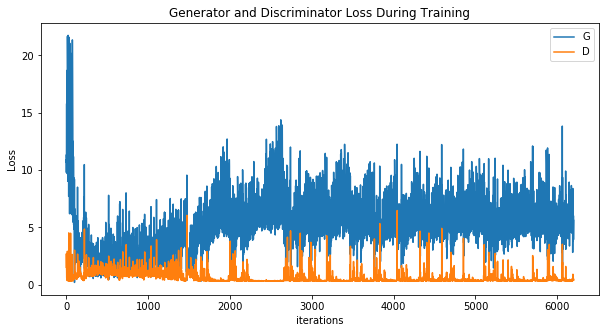

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

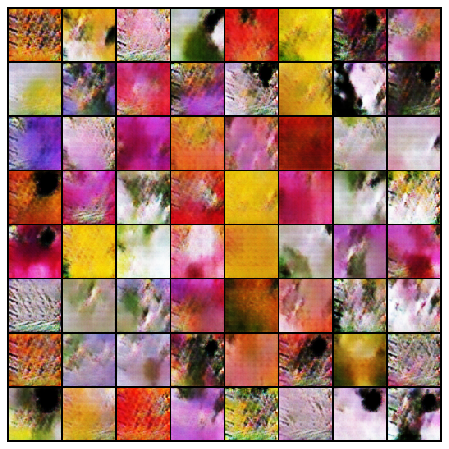

In [20]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_list]

Upon performing Training of the DCGAN model, it is obeserved that the model is slightly able to generate Face images quite similar to the input images (Identifying Petals from images).

Also, by tracking the loss values for both neural networks, it can be decided whether or not to re-train the model with more iterations to enhance image generation.

# Predicting DCGAN

In [21]:
output_dir = './data/flowers/prediction/'

In [22]:
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

In [23]:
# Loading the Generator State from the training phase
generator = Generator(ngpu).to(device)
checkpoint = torch.load('./data/flowers/checkpoints/flowers_checkpoint.pth.tar')
generator.load_state_dict(checkpoint['state_dict2'])
print("Generator Info:")
print(generator)

Generator Info:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

In [24]:
# Sample a batch from generator
sample_batch_z = torch.randn(batch_size, nz, 1, 1).to(device)

In [25]:
# Function for performing Image Prediction
def predict():
    # sample images from generator
    fake_batch_images = generator(sample_batch_z)
    vutils.save_image(fake_batch_images.detach(), "%s/sample_from_generator_with_seed_{%d}.png" %
                                   (output_dir, manualSeed), normalize=True)

In [26]:
# Function for plotting the predicted image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.figure(figsize=(10,5))
    plt.show()

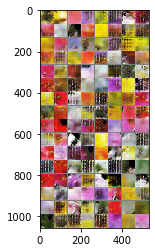

<Figure size 720x360 with 0 Axes>

Sampling Done! Image saved at ./data/flowers/prediction//sample_from_generator_with_seed_{699}.png


In [27]:
predict()
imshow(vutils.make_grid(generator(sample_batch_z).detach()))
print("Sampling Done! Image saved at %s/sample_from_generator_with_seed_{%d}.png" % ((output_dir, manualSeed)))

In [28]:
# Calculating the inception score for the predicted image
def calculate_inception_score(p_yx, eps=1E-16):
    # calculate p(y)
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    # kl divergence for each image
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
    # average over images
    avg_kl_d = mean(sum_kl_d)
    # undo the logs
    is_score = mpmath.exp(avg_kl_d)
    return is_score

In [30]:
# Conditional probabilities for high quality images
test_data = './data/flowers/prediction/sample_from_generator_with_seed_{699}.png'
inception = cv2.imread(test_data,cv2.IMREAD_UNCHANGED)
p_yx = asarray(inception)
score = calculate_inception_score(p_yx)
print(score)

1.99590455265795e+4613


##### Inception value = 25027.5135574

Upon performing Image Prediction, it is stated that the model has been trained adequately to generate good images but the model lags in predicting similar images to the the input data.

The Prediction model has been evaluated using the formula of Inception Score and the value obtained do provide good average results despite of inadequate prediction.

# Image Inpainting with DCGAN

In [37]:
num_iters = 2000
lamd = 0.1
save_dir = './data/flowers/inpainted_data'
test_data = './data/flowers/resized_flowers/val/data/image_07269.jpg'

In [32]:
# Loading Generator and Discriminator Networks
generator = Generator(ngpu)
discriminator = Discriminator(ngpu)

# Moving generator and disciminator to cuda device
generator.to(device)
discriminator.to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [33]:
# loading Generator and Discriminator network states
checkpoint = torch.load('./data/flowers/checkpoints/flowers_checkpoint.pth.tar')
print("load trained state dict from local files...")
generator.load_state_dict(checkpoint['state_dict2'])
discriminator.load_state_dict(checkpoint['state_dict1'])
print("generator and discriminator state dict loaded, done.")

print("Generator Info:")
print(generator)
print("Discriminator Info:")
print(discriminator)

load trained state dict from local files...
generator and discriminator state dict loaded, done.
Generator Info:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
 

In [34]:
image_shape = [nc, image_size, image_size]

criteria = nn.BCELoss()

In [38]:
# Function for performing Image Inpainting
def impainting():
    # Create output folder
    source_imagedir = os.path.join(save_dir, "source_images")
    masked_imagedir = os.path.join(save_dir, "masked_images")
    impainted_imagedir = os.path.join(save_dir, "impainted_images")
    os.makedirs(source_imagedir, exist_ok=True)
    os.makedirs(masked_imagedir,exist_ok=True)
    os.makedirs(impainted_imagedir,exist_ok=True)
    
    # How many pictures need to be repaired in total
    num_images = len(test_data)
    # How many batches can be divided into total for processing
    num_batches = int(np.ceil(num_images / batch_size))
    for idx in range(num_batches):
        # Perform the following processing for each batch image
        lidx = idx * batch_size
        hidx = min(num_images, (idx + 1) * batch_size)
        realBatchSize = hidx - lidx

        batch_images = [get_tensor_image(imgpath) for imgpath in glob.glob(test_data[lidx:hidx])]
        batch_images = torch.stack(batch_images).to(device)
        
        # The input original picture is ready, start to prepare the mask
        # Temporarily only provide center mask
        mask = torch.ones(size=image_shape).to(device)
        imageCenterScale = 0.3
        lm = int(image_size * imageCenterScale)
        hm = int(image_size * (1 - imageCenterScale))
        #Mask the center of the image to 0
        mask[:,lm:hm, lm:hm] = 0.0
        masked_batch_images = torch.mul(batch_images, mask).to(device)
        
        # First save the original picture and masked picture
        save_tensor_images(batch_images.detach(),
                   os.path.join(source_imagedir,"source_image_batch_{}.png".format(idx)))
    
        save_tensor_images(masked_batch_images.detach(), os.path.join(masked_imagedir, "masked_image_batch_{}.png".format(idx)))

       
        z_hat = torch.rand(size=[realBatchSize,nz,1,1],dtype=torch.float32,requires_grad=True,device=device)
        z_hat.data.mul_(2.0).sub_(1.0)
        opt = optim.Adam([z_hat],lr=learning_rate)       
        print("start impainting iteration for batch : {}".format(idx))
        v = torch.tensor(0,dtype=torch.float32,device=device)
        m = torch.tensor(0,dtype=torch.float32,device=device)
        
        for iteration in range(num_iters):
            # Iterate impainting for each batch image separately
            if z_hat.grad is not None:
                z_hat.grad.data.zero_()
            generator.zero_grad()
            discriminator.zero_grad()
            batch_images_g = generator(z_hat)
            batch_images_g_masked = torch.mul(batch_images_g,mask) 
            impainting_images = torch.mul(batch_images_g,(1-mask)) + masked_batch_images
            if iteration % 100==0:
                # Save impainting picture result
                print("\nsaving impainted images for batch: {} , iteration:{}".format(idx,iteration))
                save_tensor_images(impainting_images.detach(), os.path.join(impainted_imagedir,"impainted_image_batch_{}_iteration_{}.png".format(idx,iteration)))

            loss_context = torch.norm(
                (masked_batch_images-batch_images_g_masked),p=1)
            dis_output = discriminator(impainting_images)

            batch_labels = torch.full((realBatchSize,), 1, device=device)
            loss_perceptual = criteria(dis_output,batch_labels)
            
            total_loss = loss_context + lamd*loss_perceptual
            print("\r batch {} : iteration : {:4} , context_loss:{:.4f},perceptual_loss:{:4f}".format(idx,iteration,loss_context,loss_perceptual),end="")
            total_loss.backward()
            opt.step()

In [39]:
impainting()

start impainting iteration for batch : 0

saving impainted images for batch: 0 , iteration:0
 batch 0 : iteration :   99 , context_loss:272758.0312,perceptual_loss:2.468180
saving impainted images for batch: 0 , iteration:100
 batch 0 : iteration :  199 , context_loss:250888.6562,perceptual_loss:2.417938
saving impainted images for batch: 0 , iteration:200
 batch 0 : iteration :  299 , context_loss:235417.0469,perceptual_loss:2.385501
saving impainted images for batch: 0 , iteration:300
 batch 0 : iteration :  399 , context_loss:224398.0000,perceptual_loss:2.332325
saving impainted images for batch: 0 , iteration:400
 batch 0 : iteration :  499 , context_loss:216190.4688,perceptual_loss:2.245455
saving impainted images for batch: 0 , iteration:500
 batch 0 : iteration :  599 , context_loss:209791.7969,perceptual_loss:2.147842
saving impainted images for batch: 0 , iteration:600
 batch 0 : iteration :  699 , context_loss:204724.0625,perceptual_loss:2.069196
saving impainted images for b

Upon performing Image Inpainting application on the Flowers Test Dataset, it is observed that the images reconstructed from masked images, exhibit the presence of Perceptual Information but lacks in reconstructing images from Contextual information presnet in original images.

## Conlusion for Experiment 2:

This experiment demonstrates that Training and Inpainting Results are moderately good, but Prediction results are a bit above average for the Flowers dataset. This is due to the complexity of attributes within images of the dataset as mentioned earlier. 

There are bit more uncertainties related to few generated images, but the images generated are better with the implementation of the Prediction model. 

The next experiment will focus on the final scenario of the complexity of image.